<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>

# Random Forests (RF) for classification with Python

Estimated time needed: **45** minutes

## Objectives

After completing this lab you will be able to:

*   Understand the difference between Bagging and Random Forest
*   Understand  that Random Forests have less Correlation between predictors in their ensemble, improving accuracy
*   Apply Random Forest
*   Understand Hyperparameters selection in  Random Forest


In this notebook, you will learn Random Forests (RF) for classification and Regression. Random Forest is similar to Bagging using multiple model versions and aggregating the ensemble of models to make a single prediction. RF uses an ensemble of tree’s and introduces randomness into each tree by randomly selecting a subset of the features for each node to split on. This makes the predictions of each tree uncorrelated, improving results when the models are aggregated. In this lab, we will illustrate the sampling process of RF to Bagging, then demonstrate how each predictor for random forest are not correlated. Finally, we will apply Random Forests to several datasets using Grid-Search to find the optimum  Hyperparameters.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#RFvsBag">What's the difference between RF and Bagging </a></li>
        <li><a href="https://#Example">Cancer Data Example</li>
        <li><a href="https://practice/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01">Practice</a></li>

</div>
<br>
<hr>


Let's first import the required libraries:


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [2]:
import pandas as pd
import pylab as plt
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm


Ignore error warnings


In [3]:
import warnings
warnings.filterwarnings('ignore')

This function will calculate the accuracy of the training and testing data given a model.


In [5]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {
        "test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),
        "trian Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

This function calculates the average correlation between predictors and displays the pairwise correlation between  predictors.


In [6]:

def get_correlation(X_test, y_test,models):
    #This function calculates the average correlation between predictors  
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})
    
    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test.to_numpy())
    
    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    return corr


<h2 id="RFvsBag">  What's the difference between RF and Bagging </h2>


RF is similar to Bagging in that it uses model ensembles to make predictions. Unlike Bagging, when you add more models, RF does not suffer from Overfitting. In this section, we go over some of the differences between RF and Bagging, using the dataset:


### About the dataset

We will use a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically, it is less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.

This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

The dataset includes information about:

*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they had been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents


Load Data From CSV File


In [7]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv")

churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


### Data pre-processing and feature selection


Let's select some features for the modeling. Also, we change the target data type to be an integer, as it is a requirement by the skitlearn algorithm:


In [8]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


### Bootstrap Sampling

Bootstrap Sampling is a method that involves drawing sample data repeatedly with replacement from a data source to estimate a model parameter. Scikit-learn has methods for Bagging, but it is helpful to understand Bootstrap Sampling. We will import "resample".


In [9]:
from sklearn.utils import resample

In [12]:
resample??

Signature:
resample(
    *arrays,
    replace=True,
    n_samples=None,
    random_state=None,
    stratify=None,
)
Source:   
@validate_params(
    {
        "replace": ["boolean"],
        "n_samples": [Interval(numbers.Integral, 1, None, closed="left"), None],
        "random_state": ["random_state"],
        "stratify": ["array-like", None],
    },
    prefer_skip_nested_validation=True,
)
def resample(*arrays, replace=True, n_samples=None, random_state=None, stratify=None):
    """Resample arrays or sparse matrices in a consistent way.

    The default strategy implements one step of the bootstrapping
    procedure.

    Parameters
    ----------
    *arrays : sequence of array-like of shape (n_samples,) or \
            (n_samples, n_outputs)
        Indexable data-structures can be arrays, lists, dataframes or scipy
        sparse matrices with consistent first dimension.

    replace : bool, default=True
        Implements resampling with replacement. If False, this will implem

Consider the first five rows of data:


In [10]:
churn_df[0:5]

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


We can perform a bootstrap sample using the function "resample"; we see the dataset is of the same size(5), but some rows are repeated:


In [11]:
for n in range(5):

    print(resample(churn_df[0:5])) # n_samples is none by default thus the result will has same row as the input data.

   tenure   age  address  income   ed  employ  equip  callcard  wireless  \
3    38.0  35.0      5.0    76.0  2.0    10.0    1.0       1.0       1.0   
1    33.0  33.0     12.0    33.0  2.0     0.0    0.0       0.0       0.0   
1    33.0  33.0     12.0    33.0  2.0     0.0    0.0       0.0       0.0   
2    23.0  30.0      9.0    30.0  1.0     2.0    0.0       0.0       0.0   
0    11.0  33.0      7.0   136.0  5.0     5.0    0.0       1.0       1.0   

   churn  
3      0  
1      1  
1      1  
2      0  
0      1  
   tenure   age  address  income   ed  employ  equip  callcard  wireless  \
2    23.0  30.0      9.0    30.0  1.0     2.0    0.0       0.0       0.0   
3    38.0  35.0      5.0    76.0  2.0    10.0    1.0       1.0       1.0   
3    38.0  35.0      5.0    76.0  2.0    10.0    1.0       1.0       1.0   
4     7.0  35.0     14.0    80.0  2.0    15.0    0.0       1.0       0.0   
1    33.0  33.0     12.0    33.0  2.0     0.0    0.0       0.0       0.0   

   churn  
2      0 

### Select Variables at Random


Like Bagging, RF uses an independent bootstrap sample from the training data. In addition, we select $m$ variables at random out of all $M$ possible
variables. Let's do an example.


In [13]:
X=churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']]

there are 7 features


In [14]:
M=X.shape[1]
M

7

Let us select $𝑚=3$, and randomly sample features from the 5 Bootstrap Samples from above.


In [15]:
m=3

We list out the index of the features


In [16]:
feature_index= range(M)
feature_index

range(0, 7)

We can use the function to sample to  randomly select indexes


In [17]:
import random
random.sample(feature_index,m) # return subset with volume m form feature_index

[3, 5, 4]

We now randomly select features from the bootstrap samples to randomly select a subset of features for each node to split on.


In [18]:
for n in range(5):

    print("sample {}".format(n))
    print(resample(X[0:5]).iloc[:,random.sample(feature_index,m)])

sample 0
   income  address   ed
2    30.0      9.0  1.0
4    80.0     14.0  2.0
2    30.0      9.0  1.0
3    76.0      5.0  2.0
3    76.0      5.0  2.0
sample 1
   equip  tenure  address
2    0.0    23.0      9.0
1    0.0    33.0     12.0
2    0.0    23.0      9.0
3    1.0    38.0      5.0
3    1.0    38.0      5.0
sample 2
    ed  income  address
2  1.0    30.0      9.0
1  2.0    33.0     12.0
3  2.0    76.0      5.0
3  2.0    76.0      5.0
4  2.0    80.0     14.0
sample 3
   address  income   age
0      7.0   136.0  33.0
1     12.0    33.0  33.0
0      7.0   136.0  33.0
1     12.0    33.0  33.0
0      7.0   136.0  33.0
sample 4
   address  income  tenure
3      5.0    76.0    38.0
2      9.0    30.0    23.0
2      9.0    30.0    23.0
2      9.0    30.0    23.0
2      9.0    30.0    23.0


In Random Forest, we would use these data subsets to train each node of a tree.


## Train/Test dataset


Let's define X, and y for our dataset:


In [19]:
y = churn_df['churn']
y.head()

0    1
1    1
2    0
3    0
4    0
Name: churn, dtype: int64

## Train/Test dataset


We split our dataset into train and test set:


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)
print ('Train set', X_train.shape,  y_train.shape)
print ('Test set', X_test.shape,  y_test.shape)

Train set (140, 7) (140,)
Test set (60, 7) (60,)


### Bagging  Review


In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Bagging improves models that suffer from overfitting; they do well on the training data, but they do not generalize well to unseen data. Decision Trees are a prime candidate for this reason. In addition, they are fast to train; We create a <code>BaggingClassifier</code> object,  with a Decision Tree as the <code>base_estimator</code>.


In [25]:
n_estimators=20
Bag= BaggingClassifier(
    estimator=DecisionTreeClassifier(
        criterion="entropy", max_depth = 4,random_state=2),n_estimators=n_estimators,random_state=0,bootstrap=True)

We fit the model:


In [26]:
Bag.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=4,
                                                   random_state=2),
                  n_estimators=20, random_state=0)

The method <code>predict</code> aggregates the predictions by voting:


In [27]:
Bag.predict(X_test).shape

(60,)

We see the training accuracy is slightly better but the test accuracy improves dramatically:


In [28]:
print(get_accuracy(X_train, X_test, y_train, y_test,  Bag))

{'test Accuracy': 0.7333333333333333, 'trian Accuracy': 0.9071428571428571}


Each tree is similar; we can see this by plotting the correlation between each tree and the average correlation.


In [30]:
get_correlation(X_test, y_test,Bag).style.background_gradient(cmap='coolwarm')


Average correlation between predictors:  0.25400671537472364


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9,estimator 10,estimator 11,estimator 12,estimator 13,estimator 14,estimator 15,estimator 16,estimator 17,estimator 18,estimator 19,estimator 20
estimator 1,1.000000,-0.057709,0.152641,0.132379,0.068323,0.195047,0.209679,0.256111,0.177811,0.318511,-0.024845,0.318511,0.209679,0.112611,0.294475,-0.035245,0.161491,0.161491,0.236433,0.015456
estimator 2,-0.057709,1.000000,-0.002979,0.335171,0.349647,0.121829,-0.078409,0.013546,0.180022,0.223814,0.451486,-0.074605,-0.078409,0.404443,0.246580,0.481571,0.044130,0.044130,0.215365,-0.059131
estimator 3,0.152641,-0.002979,1.000000,0.395985,-0.010903,0.342381,0.455239,0.674356,0.442603,0.359425,-0.092675,0.519170,0.552099,0.296511,0.324850,0.216541,0.561502,0.479730,0.415029,0.006783
estimator 4,0.132379,0.335171,0.395985,1.000000,0.456572,0.242393,0.436809,0.427623,0.417131,0.494783,0.051331,0.415618,0.340807,0.405843,0.224442,0.199294,0.375523,0.294475,0.445634,0.194960
estimator 5,0.068323,0.349647,-0.010903,0.456572,1.000000,0.362231,-0.011036,0.090878,0.002915,0.409514,0.347826,-0.045502,0.099322,0.434355,0.294475,0.387699,0.068323,0.161491,0.315244,-0.100465
estimator 6,0.195047,0.121829,0.342381,0.242393,0.362231,1.000000,0.198030,0.370625,0.183073,0.163299,0.195047,0.244949,0.198030,0.505181,0.605983,0.158114,0.529414,0.195047,0.494975,-0.069338
estimator 7,0.209679,-0.078409,0.455239,0.436809,-0.011036,0.198030,1.000000,0.474619,0.564524,0.404226,-0.121393,0.619813,0.738562,0.323942,0.148803,0.062622,0.540752,0.430394,0.140028,0.247156
estimator 8,0.256111,0.013546,0.674356,0.427623,0.090878,0.370625,0.474619,1.000000,0.546688,0.464008,-0.074355,0.625402,0.474619,0.256776,0.283884,0.140642,0.669193,0.503960,0.454257,0.020559
estimator 9,0.177811,0.180022,0.442603,0.417131,0.002915,0.183073,0.564524,0.546688,1.000000,0.405727,-0.084533,0.491144,0.357359,0.241594,0.188913,0.314275,0.352707,0.177811,0.332877,0.079790
estimator 10,0.318511,0.223814,0.359425,0.494783,0.409514,0.163299,0.404226,0.464008,0.405727,1.000000,0.318511,0.466667,0.404226,0.392837,0.178122,0.464758,0.318511,0.318511,0.500370,0.113228


It can be shown that this correlation reduces performance. Random forest minimizes the correlation between trees, improving results.


## Random  Forest


Random forests are a combination of trees such that each tree depends on a random subset of the features and data. As a result, each tree in the forest is different and usually performs better than Bagging. The most important parameters are the number of trees and the number of features to sample. First, we import <code>RandomForestClassifier</code>.


In [31]:
from sklearn.ensemble import RandomForestClassifier

Like Bagging, increasing the number of trees improves results and does not lead to overfitting in most cases; but the improvements plateau as you add more trees. For this exxample, the number of trees in the forest (default=100):


In [32]:
n_estimators=20

<code>max_features </code>   $m$ the number of features to consider when looking for the best split. If we have M features denoted by:


In [35]:
M_features=X.shape[1]
M_features

7

If we have M features, a popular method to determine m is to use the square root of M


$m= floor(\sqrt{M}) $


In [36]:
max_features=round(np.sqrt(M_features))-1
max_features

2

In [37]:
y_test

58     1
40     0
34     0
102    0
184    0
198    1
95     1
4      0
29     0
168    0
171    1
18     0
11     0
89     0
110    0
118    0
159    1
35     0
136    1
59     0
51     0
16     0
44     0
94     0
31     0
162    0
38     0
28     0
193    0
27     0
47     0
165    0
194    0
177    0
176    0
97     1
174    1
73     0
69     0
172    1
108    0
107    1
189    0
14     0
56     0
19     1
114    0
39     0
185    0
124    0
98     0
123    1
119    0
53     0
33     1
179    0
181    0
106    0
199    0
138    1
Name: churn, dtype: int64

We use floor to make sure $m$ is an integer:


We create the RF object :


In [39]:
model = RandomForestClassifier( max_features=max_features,n_estimators=n_estimators, random_state=0)

We train the model


In [40]:
model.fit(X_train,y_train)

RandomForestClassifier(max_features=2, n_estimators=20, random_state=0)

We obtain the training and testing accuracy; we see that RF does better than Bagging:


In [41]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test Accuracy': 0.8, 'trian Accuracy': 0.9857142857142858}


We see that each tree in RF is less correlated with the other trees than Bagging:


In [42]:
get_correlation(X_test, y_test,model).style.background_gradient(cmap='coolwarm')

Average correlation between predictors:  0.21335179318993674


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9,estimator 10,estimator 11,estimator 12,estimator 13,estimator 14,estimator 15,estimator 16,estimator 17,estimator 18,estimator 19,estimator 20
estimator 1,1.000000,0.071067,0.339993,0.126674,0.169675,-0.052307,0.308607,0.222375,0.242393,-0.000000,0.154303,0.195047,0.385758,0.053300,0.198030,0.122279,0.077152,0.385758,0.250000,0.163299
estimator 2,0.071067,1.000000,0.174712,0.104427,0.182597,0.100366,0.358218,0.108868,0.113692,-0.031607,0.212007,0.213862,0.285112,0.363636,0.182953,0.493591,0.212007,0.065795,0.355335,0.096710
estimator 3,0.339993,0.174712,1.000000,0.287563,0.188913,0.015048,0.234061,0.314055,0.188913,0.158966,0.314772,0.440155,0.234061,0.289947,0.357359,0.212347,0.314772,0.314772,0.261533,0.234895
estimator 4,0.126674,0.104427,0.287563,1.000000,0.421270,0.208052,0.336194,0.326761,0.200195,0.401878,0.179825,0.217425,0.258009,0.318682,0.215732,0.299877,0.179825,0.101640,0.278682,0.103429
estimator 5,0.169675,0.182597,0.188913,0.421270,1.000000,0.341058,0.231893,0.283884,0.153937,0.140145,0.082285,0.213427,0.082285,0.299735,0.244805,0.182580,0.007480,0.157089,0.387829,0.178122
estimator 6,-0.052307,0.100366,0.015048,0.208052,0.341058,1.000000,-0.008071,0.081422,0.112841,0.158966,-0.088782,0.440155,0.072640,0.373585,0.253777,0.058843,0.153351,0.153351,0.183073,0.149478
estimator 7,0.308607,0.358218,0.234061,0.336194,0.231893,-0.008071,1.000000,0.282131,0.231893,0.358382,0.285714,0.326762,0.365079,0.263181,0.437978,0.332078,0.047619,0.126984,0.231455,0.125988
estimator 8,0.222375,0.108868,0.314055,0.326761,0.283884,0.081422,0.282131,1.000000,0.212015,0.340659,0.205879,0.338727,0.358382,0.189642,0.278900,0.094265,0.205879,0.510885,0.296500,-0.020174
estimator 9,0.242393,0.113692,0.188913,0.200195,0.153937,0.112841,0.231893,0.212015,1.000000,0.068276,0.306697,0.294475,0.381501,0.067182,0.340807,0.253715,0.007480,0.082285,0.096957,0.019791
estimator 10,-0.000000,-0.031607,0.158966,0.401878,0.140145,0.158966,0.358382,0.340659,0.068276,1.000000,0.053376,0.256111,0.282131,0.189642,0.278900,0.021753,0.129628,-0.022875,0.222375,0.141220


<h2 id="Example">Cancer Data Example</h2>

The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[[http://mlearn.ics.uci.edu/MLRepository.html](http://mlearn.ics.uci.edu/MLRepository.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01)]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>

Let's load the dataset:


In [43]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv")

df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Now lets remove rows that have a ? in the <code>BareNuc</code> column:


In [44]:
df= df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]

We obtain the features:


In [45]:
X =  df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]

X.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


We obtain the class labels:


In [46]:
y=df['Class']
y.head()

0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: int64

<Axes: xlabel='Class'>

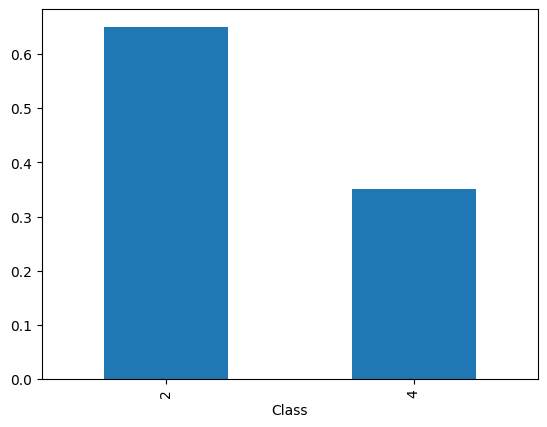

In [53]:
y.value_counts(normalize=True).plot(kind="bar")

We split the data into training and testing sets.


In [54]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


We use <code>GridSearchCV</code> to search over specified parameter values  of the model.


In [55]:
from sklearn.model_selection import GridSearchCV

We create a <code>RandomForestClassifier</code> object and list the parameters using the method <code>get_params()</code>:


In [56]:
model = RandomForestClassifier()
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

We can use GridSearch for Exhaustive search over specified parameter values. We see many of the parameters are similar to Classification trees; let's try a different parameter for <code>max_depth</code>, <code>max_features</code> and <code>n_estimators</code>.


In [58]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}
param_grid

{'n_estimators': [1,
  3,
  5,
  7,
  9,
  11,
  13,
  15,
  17,
  19,
  21,
  23,
  25,
  27,
  29,
  31,
  33,
  35,
  37,
  39],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'max_features': ['auto', 'sqrt', 'log2']}

We create the Grid Search object and fit it:


In [59]:
search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy')
search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

We can see the best accuracy score of the searched parameters was \~98%.


In [60]:
search.best_score_

0.9798832360300251

The best parameter values are:


In [61]:
search.best_params_

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 17}

We can calculate accuracy on the test data using the test data:


In [62]:

print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.9708029197080292, 'trian Accuracy': 0.9963369963369964}


<h2 id="practice">Practice</h2>


Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient.


In [63]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv", delimiter=",")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


Let's create the X and y for our dataset:


In [64]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

In [65]:
y = df["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

<Axes: xlabel='Drug'>

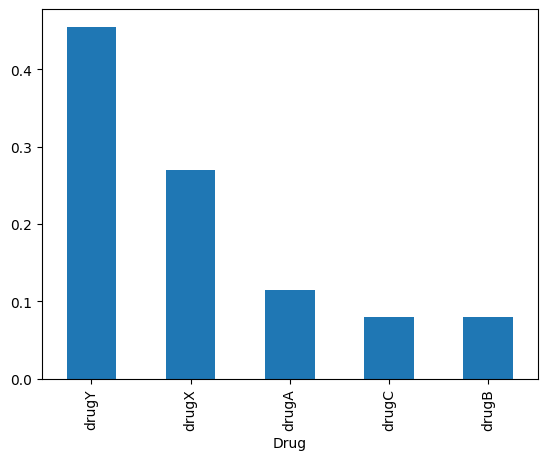

In [66]:
y.value_counts(normalize=True).plot(kind="bar")

Now lets use a <code>LabelEncoder</code> to turn categorical features into numerical:


In [67]:
from sklearn import preprocessing
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M']) # you can give then a specific order to remove the variance
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

Split the data into training and testing data with a 80/20 split


In [68]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (160, 5) (160,)
Test set: (40, 5) (40,)


<Axes: xlabel='Drug'>

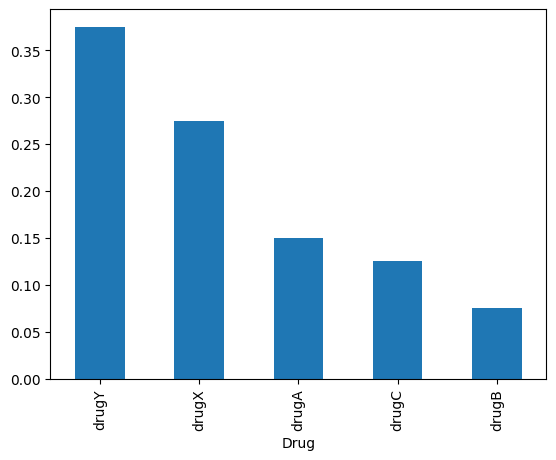

In [71]:
y_test.value_counts(normalize=True).plot(kind="bar")

We can use GridSearch for Exhaustive search over specified parameter values.


In [73]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}
param_grid

{'n_estimators': [1,
  3,
  5,
  7,
  9,
  11,
  13,
  15,
  17,
  19,
  21,
  23,
  25,
  27,
  29,
  31,
  33,
  35,
  37,
  39],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'max_features': ['auto', 'sqrt', 'log2']}

Create a <code>RandomForestClassifier </code>object called <cood>model</code> :


In [76]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()


<details><summary>Click here for the solution</summary>

```python
model = RandomForestClassifier()

```

</details>


Create <code>GridSearchCV</code> object called `search` with the `estimator` set to <code>model</code>, <code>param_grid</code> set to <code>param_grid</code>, <code>scoring</code> set to <code>accuracy</code>, and  <code>cv</code> set to 3 and Fit the <code>GridSearchCV</code> object to our <code>X_train</code> and <code>y_train</code> data


In [77]:
search = GridSearchCV(estimator=model, param_grid=param_grid,scoring="accuracy", cv=3)

search = search.fit(X_train,y_train)

<details><summary>Click here for the solution</summary>

```python
search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy', cv=3)
search.fit(X_train, y_train)

```

</details>


We can find the accuracy of the best model.


In [78]:
search.best_score_

1.0

We can find the best parameter values:


In [79]:
search.best_params_

{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 27}

We can find the accuracy test data:


In [80]:
y_hat = search.best_estimator_.predict(X_test)

In [86]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.95, 'trian Accuracy': 1.0}


<details><summary>Click here for the solution</summary>

```python
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))
```

</details>


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="https://www.ibm.com/analytics/spss-statistics-software?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01&utm_medium=Exinfluencer&utm_term=10006555">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://www.ibm.com/cloud/watson-studio?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01&utm_medium=Exinfluencer&utm_term=10006555">Watson Studio</a>


### Thank you for completing this lab!

## Author

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a>

### Other Contributors

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
| ----------------- | ------- | ---------- | ------------------ |
| 2022-02-09        | 0.1     | Joseph Santarcangelo | Created Lab Template |
| 2022-05-03        | 0.2     | Richard Ye           | QA pass              |


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
